<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/04_training_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형 모델 훈련

선형 회귀 모델을 훈련하는 방법에는 크게 2가지가 있다.
- 직접 계산할 수 있는 공식을 사용해 훈련세트에 가장 잘맞는 모델을 __해석적__으로 구한다.
- __경사하강법(GD)__으로 모델 파라미터를 수정하여 훈련세트의 비용함수를 최소하하여 구한다.

## 선형 회귀

앞 장에서, RMSE(Root MSE)를 최소하하는 $\theta$를 찾았지만, MSE를 최소화 하는 $\theta$를 찾는 방법과 같다. <br>
실제로 비용함수(Cost function)로 MSE를 사용해야 미분 특성상 계산이 단순하고, 규제(Regularization)적용이 가능하다.


### 정규 방정식

normal equation이라고 불리고, 식은 다음과 같다. <br>
<center> $\hat{\theta} = (X^{t}X)^{-1}X^{t}y$ </center> 

데이터를 무작위로 추출하여 정규방정식으로 계산 결과를 살펴보자

In [22]:
# 데이터 생성
import numpy as np
X = 2* np.random.rand(100, 1) # 임의의 x를 추출하여
y = 4 + 3 * X + np.random.randn(100, 1) # noise 추가

In [23]:
# summing vector 추가
X_b = np.c_[np.ones((100, 1)), X]
# theta 계산
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.10384137],
       [2.82572272]])

임의의 새로운 데이터 $x_{0}=(0,2)^{t}$에 대한 $\hat{y}_{0}$ 계산

In [24]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.10384137],
       [9.75528681]])

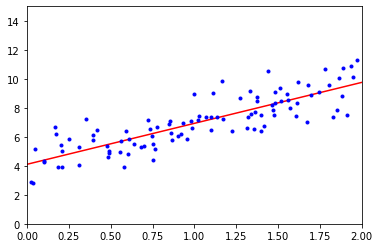

In [25]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
lin_reg.intercept_, lin_reg.coef_, lin_reg.predict(X_new)

(array([4.10384137]), array([[2.82572272]]), array([[4.10384137],
        [9.75528681]]))

- 사이킷런을 사용한 결과와 완전히 동일

특성(feature)의 수가 샘플의 수보다 많아 $(X^{t}X)^{-1}$를 구할 수 없는 경우, __일반화 역행렬(Generalized inverse)__을 이용한다. <br>
특히, 